<a href="https://colab.research.google.com/github/mgontarz20/mgontarz20/blob/main/PanelSterowaniaGC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Imports


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/BadaniaMchtr')
import numpy as np
import os
import tqdm
from tqdm import tqdm
from keras.losses import MeanSquaredError, SparseCategoricalCrossentropy
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import img_to_array, load_img
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.layers import Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard,CSVLogger,LambdaCallback
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from datetime import datetime

import json


#User Imports

In [ ]:
import genConfig
import plotter
import UNetResNet_5lvl

# Definition of hyperparameters

In [ ]:
test_size = 0.25
random_state = 10
n_filters = 4
stop_patience = 21
batch_size = 16
epoch_limit = 200
norm = False
coeff = 1.0
if norm:
    coeff = 255.0
activation_function = 'relu'

#Name definition



In [ ]:
date = datetime.now().strftime("%m-%d-%Y_%H-%M-%S")
root = '/content/drive/MyDrive/BadaniaMchtr/'
pathtoDataSet = f"{root}Datasets/"
dataset = "dataset_9_Combined_to_pred_256x256_10-11-2021_11-24-53"
type1 = "resc_wrpd"
type2 = "resc"
comment = "SSIMloss"
name = f"UNetResNet5lvl_{type1}_{date}_{comment}"

# Path Definition
# Folder Generation

In [ ]:
os.makedirs(f'{root}Results/{name}', exist_ok=True)
os.makedirs(f'{root}Results/{name}/model', exist_ok=True)
os.makedirs(f'{root}Results/{name}/cfg', exist_ok=True)
cfg_dir = f'{root}Results/{name}/cfg'

In [ ]:
path_to_inputs = os.path.join(pathtoDataSet,dataset,type1).replace("\\", "/")
path_to_outputs = os.path.join(pathtoDataSet,dataset,type2).replace("\\", "/")
print(f"Input path: {path_to_inputs}")
print(f"Output path: {path_to_outputs}")

Input path: /content/drive/MyDrive/BadaniaMchtr/Datasets/dataset_9_Combined_to_pred_256x256_10-11-2021_11-24-53/resc_wrpd
Output path: /content/drive/MyDrive/BadaniaMchtr/Datasets/dataset_9_Combined_to_pred_256x256_10-11-2021_11-24-53/resc


# Custom Functions (Callbacks, Loss)

In [ ]:
json_log = open(f'{root}Results/{name}/{name}_loss_log.json', mode='wt', buffering=1)
json_logging_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: json_log.write(
        json.dumps({'epoch': epoch, 'loss': logs['loss']}) + '\n'),
    on_train_end=lambda logs: json_log.close())

In [ ]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 255.0))

In [ ]:
callbacks = [
    EarlyStopping(patience=stop_patience, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0000001, verbose=1),
    ModelCheckpoint(f'{root}Results/{name}/model/{name}.h5', verbose=1, save_best_only=True),
    #Tensordash(ModelName=f"{name}", email='mgontarz15@gmail.com', password='dupadupa'),
    TensorBoard(log_dir=f"{root}Results/{name}/model/logs", write_graph=True, write_images= True, update_freq=5),
    CSVLogger(f"{root}Results/{name}/model/{name}.csv"),
    json_logging_callback,
            ]

#Importing Images

In [ ]:
# inputs = os.listdir(path_to_inputs)
# outputs = os.listdir(path_to_outputs)
# print(len(inputs))
# print(len(outputs))
# inputs.sort()
# outputs.sort()

# X = np.zeros((len(inputs), 256, 256, 1))
# y = np.zeros((len(outputs), 256, 256, 1))
# print(X.shape, y.shape)

In [ ]:
#!unrar x "/content/drive/MyDrive/BadaniaMchtr/Datasets/dataset_9_Combined_to_pred_256x256_10-11-2021_11-24-53.rar" "/content/drive/MyDrive/BadaniaMchtr/Datasets/dataset_9_Combined_to_pred_256x256_10-11-2021_11-24-53/"

In [ ]:
X = np.load("/content/drive/MyDrive/BadaniaMchtr/Datasets/dataset_9_Combined_to_pred_256x256_10-11-2021_11-24-53/X.npy")
y = np.load("/content/drive/MyDrive/BadaniaMchtr/Datasets/dataset_9_Combined_to_pred_256x256_10-11-2021_11-24-53/y.npy")

print(X.shape, y.shape)

(5001, 256, 256, 1) (5001, 256, 256, 1)


In [ ]:
# for i in tqdm(range(len(inputs)), desc="IMPORTING IMAGES: "):

#     wrapped = img_to_array(load_img(os.path.join(path_to_inputs, inputs[i]).replace('\\','/'), color_mode="grayscale"))
#     wrapped = resize(wrapped, (256,256,1), mode = 'constant', preserve_range = True)
#     # Load unwrapped images (outputs)
#     unwrapped = img_to_array(load_img(os.path.join(path_to_outputs, outputs[i]).replace('\\','/'), color_mode="grayscale"))
#     unwrapped = resize(unwrapped, (256,256,1), mode = 'constant', preserve_range = True)

#     X[i] = wrapped.astype('float32')/coeff
#     y[i] = unwrapped.astype('float32')/coeff

# print(len(X))
# print(len(y))

In [ ]:
genConfig.write_cfg(cfg_dir, name, 'w', type_input = type1, type_output= type2, dataset = dataset)

# Train Test Splitting


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=random_state)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
del X
del y

(3750, 256, 256, 1) (1251, 256, 256, 1) (3750, 256, 256, 1) (1251, 256, 256, 1)


In [ ]:
genConfig.write_cfg(cfg_dir, name, "a", test_size = test_size, random_state = random_state)

#Model Loading and Initialization

In [ ]:
input_img = Input((256, 256, 1), name='img')
model = UNetResNet_5lvl.get_unet(input_img, n_filters=n_filters, activation=activation_function)
model.compile(optimizer=Adam(learning_rate=0.01), loss=SSIMLoss,  metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 4)  40          img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 4)  16          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 4)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
genConfig.write_cfg(cfg_dir,name, 'a', optimizer = "Adam", loss = comment, metrics = "accuracy", state = "new", n_filters = n_filters)

#Model Fitting

In [ ]:
start = datetime.now()
results = model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch_limit, callbacks=callbacks,
                     validation_data=(X_valid, y_valid))

stop = datetime.now()

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/200
235/235 [==============================] - 116s 333ms/step - loss: 0.2366 - accuracy: 0.0853 - val_loss: 0.1544 - val_accuracy: 0.0419

Epoch 00001: val_loss improved from inf to 0.15444, saving model to /content/drive/MyDrive/BadaniaMchtr/Results/UNetResNet5lvl_resc_wrpd_10-14-2021_22-11-02_SSIMloss/model/UNetResNet5lvl_resc_wrpd_10-14-2021_22-11-02_SSIMloss.h5
Epoch 2/200
235/235 [==============================] - 73s 313ms/step - loss: 0.0444 - accuracy: 0.0924 - val_loss: 0.0440 - val_accuracy: 0.0955

Epoch 00002: val_loss improved from 0.15444 to 0.04401, saving model to /content/drive/MyDrive/BadaniaMchtr/Results/UNetResNet5lvl_resc_wrpd_10-14-2021_22-11-02_SSIMloss/model/UNetResNet5lvl_resc_wrpd_10-14-2021_22-11-02_SSIMloss.h5
Epoch 3/200
235/235 [==============================] - 69s 295ms/step - loss: 0.0210 - accuracy: 0.0931 - val_loss: 0.0350 - val_accuracy: 0.0743

Epoch 00003: val_loss improved from 0.04401 to 0.03500, saving model to /content/drive/MyDrive/B

In [ ]:
time = stop - start

In [ ]:
genConfig.write_cfg(cfg_dir,name, "a", batch_size = batch_size, epoch_limit = epoch_limit, time = time, activation_function = activation_function)


#Plotting Results

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.497737 to fit



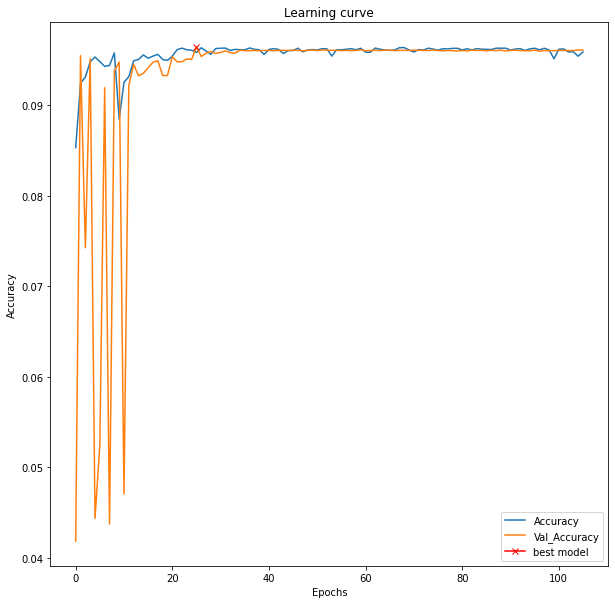

In [ ]:
plotter.plot_model_data(model, name, results, root)
genConfig.write_cfg(cfg_dir,name, "a",  best_loss = np.min(results.history["val_loss"]), for_epoch_loss = np.argmin(results.history["val_loss"]), best_acc = np.max(results.history["val_accuracy"]), for_epoch_acc = np.argmax(results.history["val_accuracy"]))


#Model Evaluation

In [ ]:
score, acc = model.evaluate(X_train, y_train,
                            batch_size=batch_size)
print('Train score:', score)
print('Train accuracy:', acc)

235/235 [==============================] - 20s 86ms/step - loss: 0.0013 - accuracy: 0.0974
Train score: 0.0012977768201380968
Train accuracy: 0.0974162146449089


In [ ]:
genConfig.write_cfg(cfg_dir,name, "a", train_score = score, train_acc =acc)


In [ ]:
score, acc = model.evaluate(X_valid, y_valid,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

79/79 [==============================] - 7s 86ms/step - loss: 0.0014 - accuracy: 0.0961
Test score: 0.0013648903695866466
Test accuracy: 0.09610448777675629


In [ ]:
genConfig.write_cfg(cfg_dir,name, "a", test_score = score, test_acc =acc)


In [ ]:
!apt-get install rar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  rar
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 295 kB of archives.
After this operation, 799 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 rar amd64 2:5.5.0-1 [295 kB]
Fetched 295 kB in 1s (470 kB/s)
Selecting previously unselected package rar.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../rar_2%3a5.5.0-1_amd64.deb ...
Unpacking rar (2:5.5.0-1) ...
Setting up rar (2:5.5.0-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [12]:
name = "UNetResNet5lvl_resc_wrpd_10-14-2021_22-11-02_SSIMloss"
!rar a '/content/drive/MyDrive/UNetResNet5lvl_resc_wrpd_10-14-2021_22-11-02_SSIMloss_Results' '/content/drive/MyDrive/BadaniaMchtr/Results/UNetResNet5lvl_resc_wrpd_10-14-2021_22-11-02_SSIMloss'
from google.colab import files
files.download("/content/drive/MyDrive/UNetResNet5lvl_resc_wrpd_10-14-2021_22-11-02_SSIMloss_Results.rar")



RAR 5.50   Copyright (c) 1993-2017 Alexander Roshal   11 Aug 2017
Trial version             Type 'rar -?' for help

Evaluation copy. Please register.

Creating archive /content/drive/MyDrive/UNetResNet5lvl_resc_wrpd_10-14-2021_22-11-02_SSIMloss_Results.rar

Adding    /content/drive/MyDrive/BadaniaMchtr/Results/UNetResNet5lvl_resc_wrpd_10-14-2021_22-11-02_SSIMloss/model/logs/train/events.out.tfevents.1634249645.1ae09c138269.profile-empty       0%  OK 
Adding    /content/drive/MyDrive/BadaniaMchtr/Results/UNetResNet5lvl_resc_wrpd_10-14-2021_22-11-02_SSIMloss/model/logs/train/plugins/profile/2021_10_14_22_14_05/1ae09c138269.trace.json.gz       1%  OK 
Adding    /content/drive/MyDrive/BadaniaMchtr/Results/UNetResNet5lvl_resc_wrpd_10-14-2021_22-11-02_SSIMloss/model/logs/train/plugins/profile/2021_10_14_22_14_05/1ae09c138269.memory_profile.json.gz       1%  OK 
Adding    /content/drive/MyDrive/BadaniaMchtr/Results/UNetResNet5lvl_resc_wrpd_10-14-2021_22-11-02_SSIMl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>